In [ ]:
## Notebook env: brian_script_env (R kernel)
## This notebook starts requires archr_obtaining_chromatin_matrices.ipynb to be run first

In [1]:
library(ggplot2)
library(ggpubr)
library(stringr)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(Matrix)
library(sparseMatrixStats)
library(dplyr)
library(rstatix)
library(ggforce)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




## Analysis ##

In [2]:
## Get 2000 or whatever Archr provides as most variable markers across all cells to lower # of genes (for 1. and 2.) or regions (for 3.) ?????
## ^actually, use the same genes used in the scRNAseq analysis to narrow down genes for this analysis (different for CRISPRi vs CRISPRa)
## require cell sampling to even out cells per sample ??
## caluculate heterogenity between cells within each sample type vs NT control
## Order of analyis:
## 1. Gene score mtx
## 2. TSS peak mtx
## 3. Total mtx

### Also FYI, the gene score mtx is made from fragments put into a model to create gene exp scores, this is a good for estimating gene expression, but not for open chromatin area.
### Peaks are called based on a predetermined procedure using fragments in a region; 
### the idea is to create a holistic estimation of open chromatin area (and a density/probability of that area/peak) to get a more accurate view of open chromatin area than the noisiness of fragment end locations allows 
### Peak matrix is mostly good for showin DNA tracks with peaks on it

### pseudobulk cells for RNF8-Ci vs NT-Ci and look for total open chromatin differences

In [3]:
### load data ###
## get genes used in CRISPRi and CRISPRa scRNAseq analysis ##
CRISPRi_scRNAseq_genes = readRDS('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/heterogeneity/CV_gene_median_aboveorequalto1_normalized_mtx_cc_regressed_CRISPRi_used_genes.rds')
#CRISPRa_scRNAseq_genes = readRDS('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRa_second_repeat_screen_deep_sequenced/heterogeneity/CV_gene_median_aboveorequalto1_normalized_mtx_cc_regressed_CRISPRa_used_genes.rds')

## get gene scores mtx ##
txnhet_archr_macs2_gene_scores_mtx = readRDS(file = '/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/archr_analysis/txnhet_archr_macs2_gene_scores_mtx.rds')
txnhet_archr_macs2_gene_scores_meta = readRDS(file = '/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/archr_analysis/txnhet_archr_macs2_gene_scores_meta.rds')

In [4]:
### CRISPRi matrix filtering ###
txnhet_archr_macs2_gene_scores_CRISPRi_meta = txnhet_archr_macs2_gene_scores_meta %>% filter(endsWith(Sample, 'Ci-1') | endsWith(Sample, 'Ci-2'))
txnhet_archr_macs2_gene_scores_CRISPRi_mtx = txnhet_archr_macs2_gene_scores_mtx[rownames(txnhet_archr_macs2_gene_scores_mtx) %in% CRISPRi_scRNAseq_genes, rownames(txnhet_archr_macs2_gene_scores_CRISPRi_meta)]
colnames(txnhet_archr_macs2_gene_scores_CRISPRi_meta)[colnames(txnhet_archr_macs2_gene_scores_CRISPRi_meta) == 'Sample'] = 'guide'

## combine replicates ##
txnhet_archr_macs2_gene_scores_CRISPRi_meta$guide = stringr::str_sub(txnhet_archr_macs2_gene_scores_CRISPRi_meta$guide, 1, -3)

## rename for analysis below ##

filtered_meta_data = txnhet_archr_macs2_gene_scores_CRISPRi_meta
filtered_raw_mtx = txnhet_archr_macs2_gene_scores_CRISPRi_mtx

In [5]:
## cells per guide count
guides = unique(filtered_meta_data$guide)

cells_per_guide = vector()
for (i in 1:length(guides)){
    cells_per_guide[i] = length(which(filtered_meta_data$guide == guides[i]))
}

cell_gd_count = data.frame(guide_name = guides, cell_count = cells_per_guide)

In [6]:
cell_gd_count

guide_name,cell_count
<fct>,<int>
RNF8-Ci,26288
MIS18A-Ci,14240
NTCi,8782


In [7]:
### divide expression mtx into a list of mtxs subsetted by guide

mtx_subsetter = function(guide_nm, matrix, meta_data){
    return(matrix[, meta_data$guide == guide_nm])}

guide_subsetted_data = pblapply(X = guides, FUN = mtx_subsetter, 
                                matrix = filtered_raw_mtx, meta_data = filtered_meta_data)

names(guide_subsetted_data) = guides

In [8]:
## control number of cells per guide to be equivalent
## throw out guides with < 3500 cells and for the remaining guides (all remain) sample 3500 cells without replacement
fixed_cell_count = 8000
guide_subsetted_data = guide_subsetted_data[cells_per_guide >= fixed_cell_count]
cells_to_discard = list()

set.seed(22)
for (i in 1:length(guide_subsetted_data)){
    idx_to_keep = sample(1:ncol(guide_subsetted_data[[i]]), fixed_cell_count, replace = FALSE)
    idx_to_discard = setdiff(1:ncol(guide_subsetted_data[[i]]), idx_to_keep)
    cells_to_discard[[i]] = colnames(guide_subsetted_data[[i]])[idx_to_discard]
    guide_subsetted_data[[i]] = guide_subsetted_data[[i]][,idx_to_keep]
}

cells_to_discard = unlist(cells_to_discard)

In [9]:
## add bkg distribution of guide subsetted mtxs to list
## this is just mtxs where the cells are randomly assigned to each guide
## the bkg distribution of mtxs is made to subtract out number of genes that are expected to have increased or decreased CV when cells assigned randomly to each guide
## Note: the number of cells assigned to each guide is kept the same
set.seed(44)

randomized_filtered_raw_mtx = Reduce(cbind, guide_subsetted_data[!startsWith(names(guide_subsetted_data), 'NT')])
randomized_cell_order = sample(colnames(randomized_filtered_raw_mtx), ncol(randomized_filtered_raw_mtx), replace = FALSE)


designation_vector = mapply(rep, guides[!startsWith(guides, 'NT')], fixed_cell_count, SIMPLIFY = TRUE)
designation_vector = unlist(designation_vector)
designation_vector = as.character(designation_vector)
split_barcodes = split(randomized_cell_order, designation_vector)
mtx_random_splitter = function(barcodes, mtx){return(mtx[,barcodes])}

guide_random_subsetted_data = pblapply(X = split_barcodes, FUN = mtx_random_splitter, mtx = randomized_filtered_raw_mtx)
guide_random_subsetted_data = c(guide_subsetted_data[startsWith(names(guide_subsetted_data), 'NT')], guide_random_subsetted_data) ##
names(guide_random_subsetted_data) = paste('random', c('NTCi', guides[!startsWith(guides, 'NT')]), sep = '_') ##
guide_subsetted_data = c(guide_subsetted_data, guide_random_subsetted_data)

In [10]:
## compare each of the guide subsetted data to the control subsetted data and
## create the following table for each guide:
## gene | CV1 (ctrl) | CV2 (gd) | CV2/CV1 | Increasing or Decreasing CV (ie CV2/CV1 > 1 or CV2/CV1 < 1) | asymptotic test p-value | q-value 


## CV calculator
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs = pblapply(X = guide_subsetted_data, FUN = CV_calculator)
names(CVs) = names(guide_subsetted_data)

In [11]:
### creating first 4 columns of the table annotated above
gene_means = lapply(guide_subsetted_data, sparseMatrixStats::rowMeans2)
gene_sds = lapply(guide_subsetted_data, sparseMatrixStats::rowSds)
names(gene_means) = names(guide_subsetted_data)
names(gene_sds) = names(guide_subsetted_data)


master_df_list = list()
for (i in 1:length(guide_subsetted_data)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['NTCi']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['NTCi']], mean_gdmean_ctrlratio = gene_means[[i]]/gene_means[['NTCi']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['NTCi']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['NTCi']], mean_gdmean_ctrlratio = gene_means[[i]]/gene_means[['NTCi']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
}



In [12]:
### creating column 5 of the table annotated above
for (i in 1:length(master_df_list)){
    master_df_list[[i]]$gene_status = 'NA'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio == 1] = 'No Change'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio > 1] = 'Increasing'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio < 1] = 'Decreasing'               
}


In [13]:
## performing CV equality aysmptotic test and adding its pval to master_df_list
cells_per_guide = rep(cells_per_guide, 2)
names(cells_per_guide) = names(guide_subsetted_data)
asymp_test_p_vals = as.data.frame(matrix(0, nrow = nrow(filtered_raw_mtx), ncol = length(master_df_list)))


for (i in 1:length(master_df_list)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['NTCi'], cells_per_guide[i]), s = c(gene_sds[['NTCi']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['NTCi']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['NTCi'], cells_per_guide[i]), s = c(gene_sds[['NTCi']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['NTCi']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }    
    }
    master_df_list[[i]]$p_val = asymp_test_p_vals[,i]
}

saveRDS(master_df_list, '/home/ssobti/projects/heterogeneity_brian/output_data/scATACseq/091724_BW/post_archr_analysis/CRISPRi_CVs.rds')

## Comparing guide CV and NT guide CV ratios ##

#### CV ratios ####

In [14]:
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NTCi', 'random_NTCi'))]
plotted_guides_with_NT = names(master_df_list)
ratios = lapply(names(master_df_list), function(x){log2(master_df_list[[x]]$CV_gdCV_ctrlratio)})
names(ratios) = plotted_guides_with_NT
ratios_df <- as.data.frame(do.call(cbind, ratios))
colnames(ratios_df) = names(master_df_list)
ratios_df = ratios_df[, !(colnames(ratios_df) %in% c('NTCi', 'random_NTCi'))]
ratios_df = tidyr::pivot_longer(ratios_df, cols = colnames(ratios_df), values_to = 'CV_gdCV_ctrlratio', names_to = 'guide')
order_of_guides = ratios_df %>% group_by(guide) %>% summarize(means = mean(CV_gdCV_ctrlratio, na.rm = T)) %>% arrange(means) %>% pull(guide) %>% as.character()
ratios_df$guide = factor(ratios_df$guide, levels = order_of_guides)

In [15]:
ratios = ratios[order_of_guides]
tests = lapply(ratios, t.test, mu = 1)
pvals = as.numeric(lapply(tests, function(x) return(x$p.val)))
pvals_adj = signif(p.adjust(pvals), 4)
pvals_adj[pvals_adj == 0] = '< e-300'

Warning message:
“Removed 14 rows containing non-finite values (stat_ydensity).”


Warning message:
“Removed 14 rows containing non-finite values (stat_sina).”


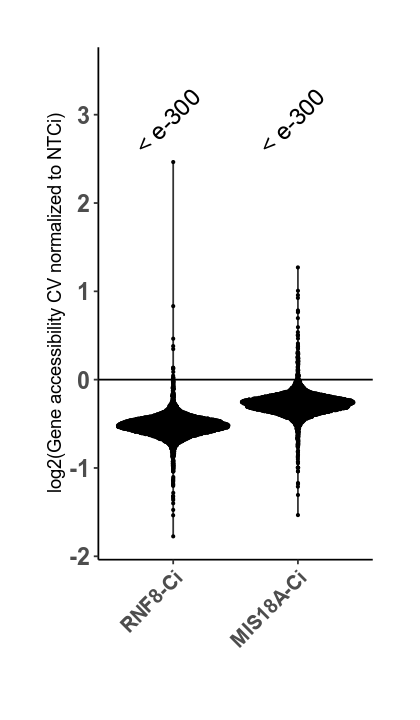

In [16]:
options(repr.plot.width = 3.5, repr.plot.height = 6)
library(ggforce)
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('NTCi', 'random_NTCi'))]
ratios_df %>% filter(guide %in% c('RNF8-Ci', 'MIS18A-Ci')) %>% ggplot(aes(guide, CV_gdCV_ctrlratio, fill = guide)) + ylab('log2(Gene accessibility CV normalized to NTCi)') + xlab('') +
  geom_violin(position=position_dodge()) + annotate("text", x = (1:length(plotted_guides))[1:2], y = 3.5, size = 5, angle='45', hjust = 1, vjust = 2.25, label = pvals_adj[c(1,4)]) +
  geom_sina(position=position_dodge(), size = 0.5) + geom_hline(yintercept = 0) + coord_cartesian(clip = 'off') +
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1))

#### CVs ####

In [17]:
plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('random_NTCi', 'random_MIS18A-Ci', 'random_RNF8-Ci'))]
plotted_guides_with_NT = names(master_df_list)
CVs_list = lapply(names(master_df_list), function(x){log2(master_df_list[[x]]$CV_gd)})
names(CVs_list) = plotted_guides_with_NT
CVs_df <- as.data.frame(do.call(cbind, CVs_list))
colnames(CVs_df) = names(master_df_list)
CVs_df = CVs_df[, !(colnames(CVs_df) %in% c('random_NTCi', 'random_MIS18A-Ci', 'random_RNF8-Ci'))]
CVs_df = tidyr::pivot_longer(CVs_df, cols = colnames(CVs_df), values_to = 'CV_gd', names_to = 'guide')
order_of_guides = CVs_df %>% group_by(guide) %>% summarize(means = mean(CV_gd, na.rm = T)) %>% arrange(means) %>% pull(guide) %>% as.character()
order_of_guides = c(order_of_guides[order_of_guides == 'NTCi'] ,order_of_guides[!order_of_guides == 'NTCi'])
CVs_df$guide = factor(CVs_df$guide, levels = order_of_guides)
saveRDS(CVs_df, '/home/ssobti/projects/heterogeneity_brian/fig_output/data/fig6/CVs_CRISPRi_violin_df.rds')

Warning message:
“Removed 21 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 21 rows containing non-finite values (stat_sina).”
Warning message:
“Removed 21 rows containing non-finite values (stat_signif).”


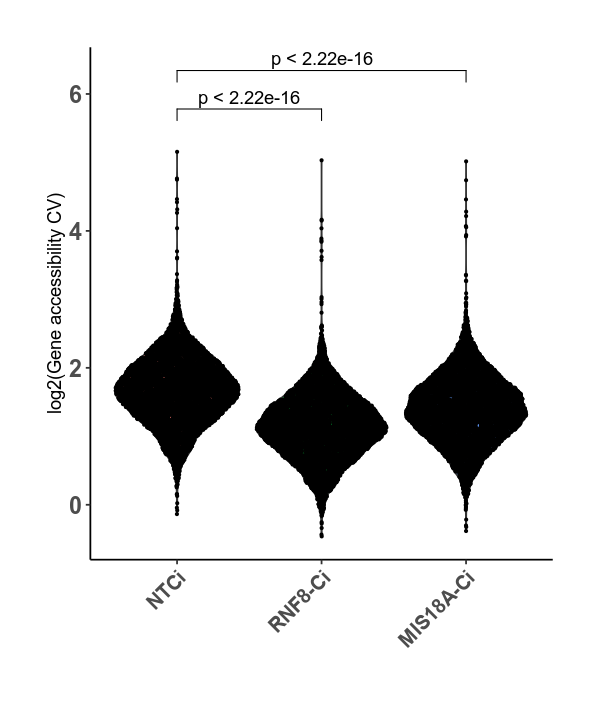

In [17]:
options(repr.plot.width = 5, repr.plot.height = 6)
library(ggforce)
#plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('random_NTCi'))]
comparisons = list(c('NTCi', 'RNF8-Ci'), c('NTCi', 'MIS18A-Ci'))
ggplot(CVs_df, aes(guide, CV_gd)) + ylab('log2(Gene accessibility CV)') + xlab('') +
  geom_violin(aes(fill = guide), position=position_dodge()) + #annotate("text", x = 1:length(plotted_guides), y = 3.5, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  geom_sina(position=position_dodge(), size = 0.5) + coord_cartesian(clip = 'off') + stat_compare_means(comparisons = comparisons, method = 't.test', label.y = 5.5, na.rm = T, step.increase = 0.1) + 
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1))

Warning message:
“Removed 21 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 21 rows containing non-finite values (stat_signif).”


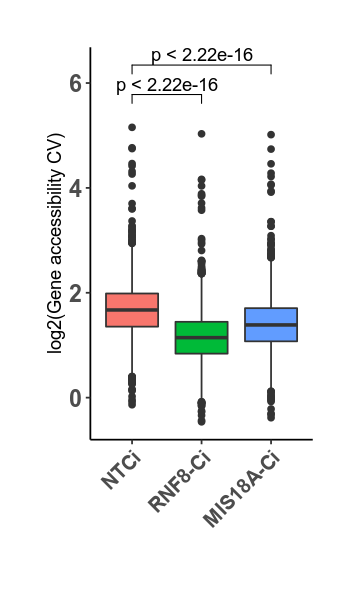

In [18]:
options(repr.plot.width = 3, repr.plot.height = 5)
library(ggforce)
#plotted_guides = names(master_df_list)[!(names(master_df_list) %in% c('random_NTCi'))]
comparisons = list(c('NTCi', 'RNF8-Ci'), c('NTCi', 'MIS18A-Ci'))
ggplot(CVs_df, aes(guide, CV_gd)) + ylab('log2(Gene accessibility CV)') + xlab('') +
  geom_boxplot(aes(fill = guide), position=position_dodge()) + #annotate("text", x = 1:length(plotted_guides), y = 3.5, size = 5, angle='45', hjust = -0.2, label = pvals_adj) +
  coord_cartesian(clip = 'off') + stat_compare_means(comparisons = comparisons, method = 't.test', label.y = 5.5, na.rm = T, step.increase = 0.1) + 
  theme_classic() + theme(plot.margin = margin(1,1,1,1, "cm"), plot.title = element_text(hjust = 0.5), legend.position = 'none', axis.text.y = element_text(face = 'bold', size = 14), axis.text.x = element_text(face = 'bold', size = 12, angle = 45, hjust = 1))